# TVD schemes

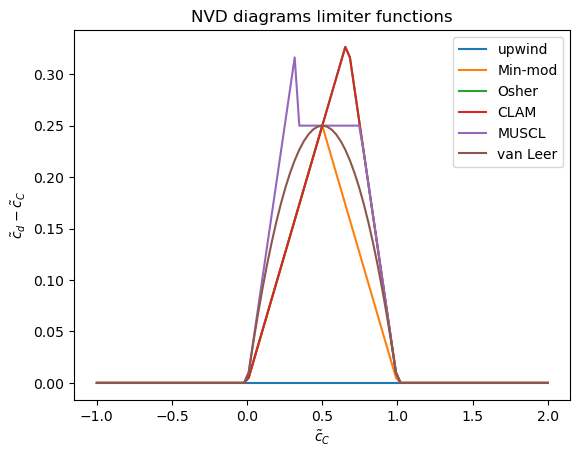

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymrm import upwind, minmod, osher, clam, muscl, vanleer

limiters= [
    (upwind, "upwind"),
    (minmod, "Min-mod"),
    (osher, "Osher"),
    (clam, "CLAM"),
    (muscl, "MUSCL"),
    (vanleer, "van Leer")
]

c=np.linspace(-1,2,99)
for func, name in limiters:
    plt.plot(c, func(c, 0.5, 0.75), label=name)
plt.title('NVD diagrams limiter functions')
plt.xlabel(r'$\tilde{c}_C$')
plt.ylabel(r'$\tilde{c}_d - \tilde{c}_C$')
plt.legend()
plt.show()

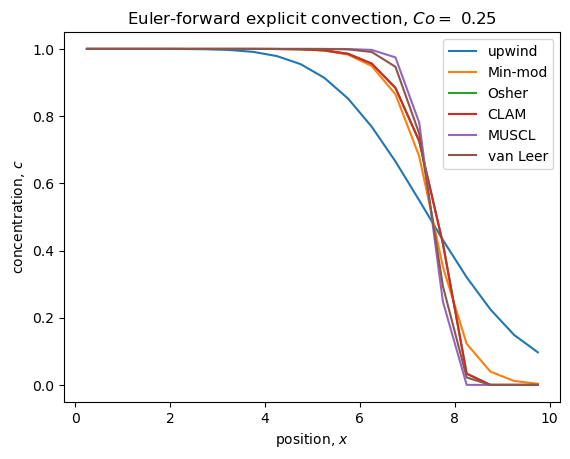

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from pymrm import interp_cntr_to_stagg_tvd
from pymrm import upwind, minmod, osher, clam, muscl, vanleer

limiters= [
    (upwind, "upwind"),
    (minmod, "Min-mod"),
    (osher, "Osher"),
    (clam, "CLAM"),
    (muscl, "MUSCL"),
    (vanleer, "van Leer")
]

L = 10;
num_x = 20;
v = 1
Co = 0.25;
dt = Co*(L/num_x)/v
num_time_steps = math.floor(0.75*num_x/Co)
x_f = np.linspace(0,L,num_x+1)
x_c = 0.5*(x_f[1:]+x_f[:-1])
bc = ({'a':0, 'b':1, 'd':1},{'a':1, 'b':0, 'd':0})

for func, name in limiters:
    c = np.zeros(num_x)
    for i in range(num_time_steps):
        c_f, dc_f = interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, tvd_limiter=func, axis=0)
        c += Co*(c_f[:-1]-c_f[1:])
    plt.plot(x_c, c, label=name)
plt.title(fr"Euler-forward explicit convection, $Co=$ {Co}")
plt.xlabel(r'position, $x$')
plt.ylabel(r'concentration, $c$')
plt.legend()
plt.show()

In [1]:
import math
import numpy as np
import scipy as sp
from scipy.sparse import linalg as sla
from pymrm import construct_convflux_upwind, construct_div, interp_cntr_to_stagg_tvd
from pymrm import upwind, minmod, osher, clam, muscl, vanleer

limiters= [
    (upwind, "upwind"),
    (minmod, "Min-mod"),
    (osher, "Osher"),
    (clam, "CLAM"),
    (muscl, "MUSCL"),
    (vanleer, "van Leer")
]

L = 10
num_x = 20
v = 1
bc = ({'a':0, 'b':1, 'd':1},{'a':1, 'b':0, 'd':0})

Co = 0.25
dt = Co*(L/num_x)/v
num_time_steps = math.floor(0.75*num_x/Co)
x_f = np.linspace(0,L,num_x+1)
x_c = 0.5*(x_f[1:]+x_f[:-1])

# Jac = (1/dt*I + Div @ Conv)
# g = (c-c_old)/dt + Div @ (Conv @ c + conv_bc + v*dc_f) 
#   = Jac @ c - c_old/dt + Div @ (conv_bc + v*dc_f)
num_inner_iter = 1
Conv, conv_bc = construct_convflux_upwind(num_x, x_f, x_c, bc, v, axis=0)
Div = construct_div(num_x, x_f, nu=0, axis=0)
Jac = (1/dt)*sp.sparse.eye(num_x, format='csc') + Div @ Conv
Jac_lu = sla.splu(Jac)
for func, name in limiters:
    c = np.zeros(num_x)
    for i in range(num_time_steps):
        c_old = c.copy()
        for j in range(num_inner_iter):
            c_f, dc_f = interp_cntr_to_stagg_tvd(c, x_f, x_c, bc, v, tvd_limiter=func, axis=0)
            g = Jac @ c.reshape(-1,1) - c_old.reshape(-1,1)/dt + Div @ (conv_bc + v*dc_f.reshape(-1,1))
            c -= Jac_lu.solve(g).reshape(c.shape)
    plt.plot(x_c, c, label=name)
plt.title(fr"Euler-backward implicit convection with deferred correction, $Co=$ {Co}")
plt.xlabel(r'position, $x$')
plt.ylabel(r'concentration, $c$')
plt.legend()
plt.show()

NameError: name 'plt' is not defined